<a href="https://colab.research.google.com/github/andydaehn/Drug_Classification/blob/main/Drug_Classify.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Drug Classification Analysis

This analysis will help predict the best drug to use for a particular patient, based on medical data from 200 patients, by classifying the patient to the drug profile.

## Import Libraries and Data

In [1]:
# Import libraries necessary for this project
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report
from IPython.display import display 

# Pretty display for notebooks
%matplotlib inline

# Ensure visualizations can be viewed by all
vis_color = 'colorblind'
hex_color = '#004c99'
cmap_color = 'jet'

# Load the dataset
explore_df = pd.read_csv('drug200.csv')

## Exploratory Data Analysis

In [2]:
# Make it easy to see basic information
def get_basic_info():
    display(explore_df.head())
    display(explore_df.describe())
    display(explore_df.info())
get_basic_info()

,Age,Sex,BP,Cholesterol,Na_to_K,Drug
0,23,F,HIGH,HIGH,25.355,DrugY
1,47,M,LOW,HIGH,13.093,drugC
2,47,M,LOW,HIGH,10.114,drugC
3,28,F,NORMAL,HIGH,7.798,drugX
4,61,F,LOW,HIGH,18.043,DrugY


,Age,Na_to_K
count,200.000000,200.000000
mean,44.315000,16.084485
std,16.544315,7.223956
min,15.000000,6.269000
25%,31.000000,10.445500
50%,45.000000,13.936500
75%,58.000000,19.380000
max,74.000000,38.247000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Age          200 non-null    int64  
 1   Sex          200 non-null    object 
 2   BP           200 non-null    object 
 3   Cholesterol  200 non-null    object 
 4   Na_to_K      200 non-null    float64
 5   Drug         200 non-null    object 
dtypes: float64(1), int64(1), object(4)
memory usage: 9.5+ KB


None

### Analysis of Numerical Features

In [3]:
# Combine all numerical features
numerical_cols = explore_df.select_dtypes(include=np.number).columns.to_list()
numerical_cols

['Age', 'Na_to_K']

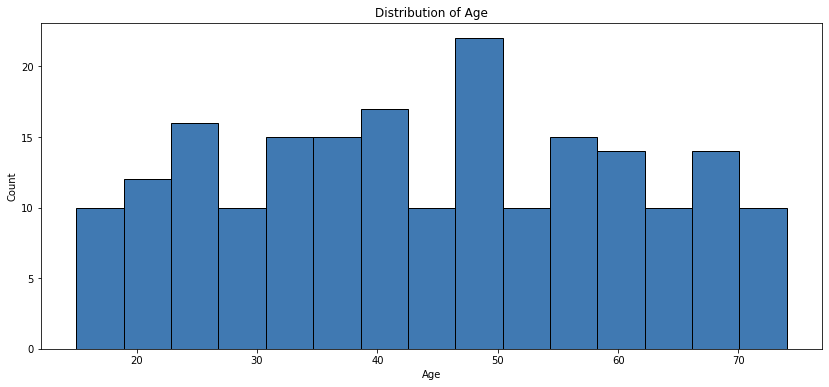

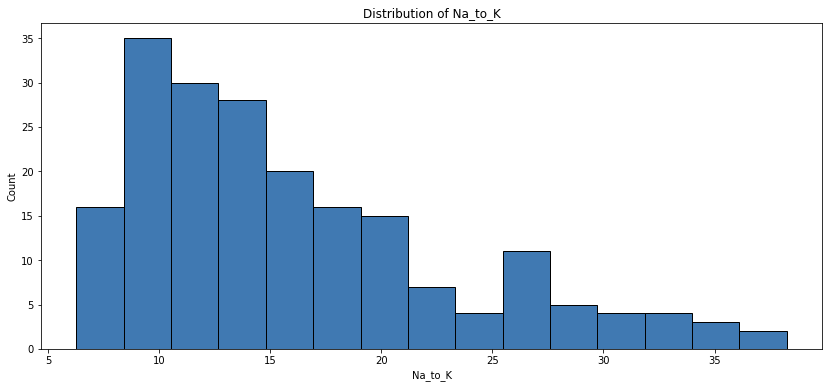

In [4]:
# Plot numerical column
for col in numerical_cols:
    plt.figure(figsize=(14,6))
    sns.histplot(data=explore_df,x=col,bins=15,color=hex_color)
    plt.title(f"Distribution of {col}")

**Inference:** Na_to_k has a positive skew. Check skewness and kurtosis of Na_to_K

In [5]:
# Skewness
print("Skewness: %f" % explore_df['Na_to_K'].skew())


Skewness: 1.039341


### Analysis of Categorical Features

In [6]:
# Combine all categorical features
categorical_cols=explore_df.select_dtypes(include=object).columns.to_list()
categorical_cols

['Sex', 'BP', 'Cholesterol', 'Drug']

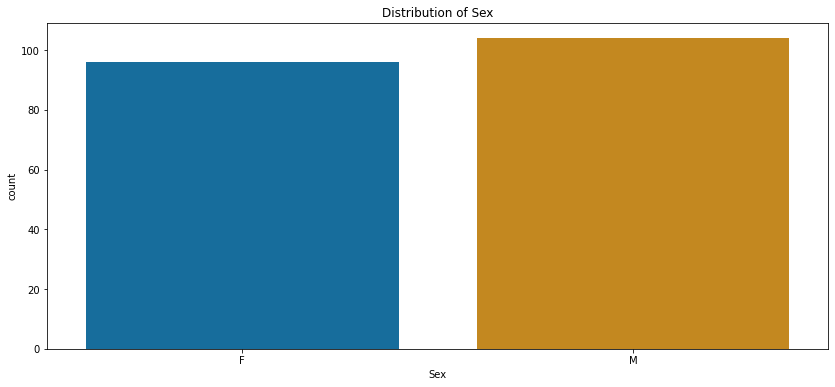

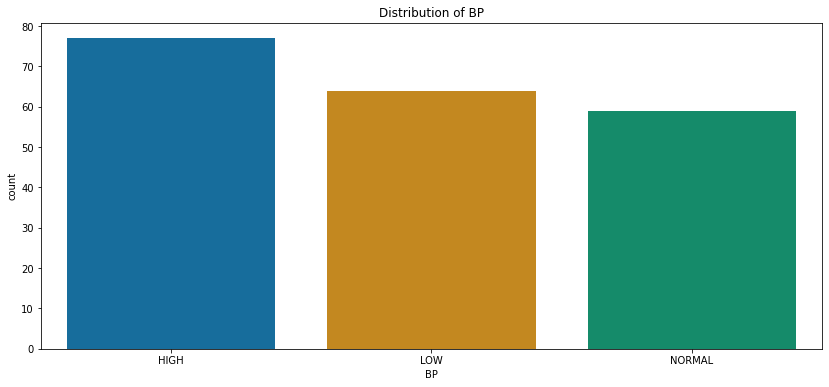

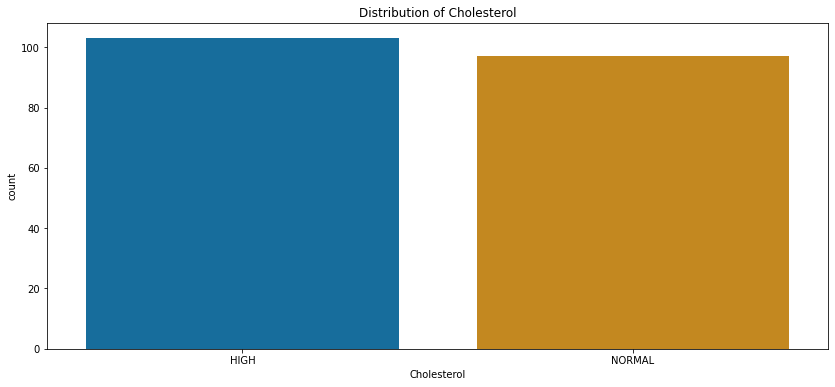

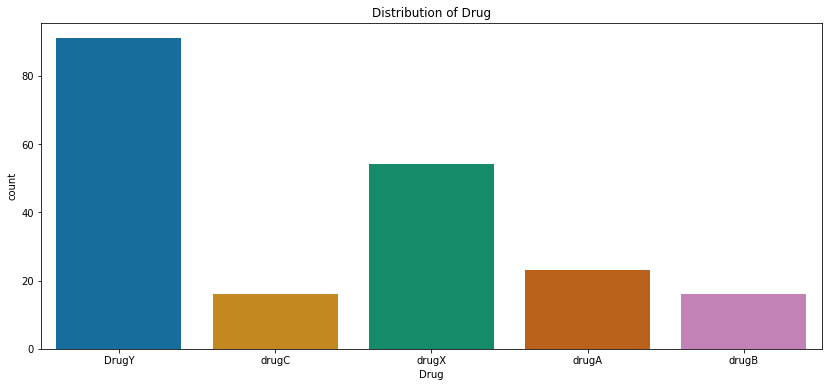

In [7]:
# Plot categorical columns
for col in categorical_cols:
    plt.figure(figsize=(14,6))
    sns.countplot(data=explore_df,x=col,palette=vis_color)
    plt.title(f"Distribution of {col}")

**Inference**: Drug Y is widely used compared to other drugs.

## Bivariate Analysis

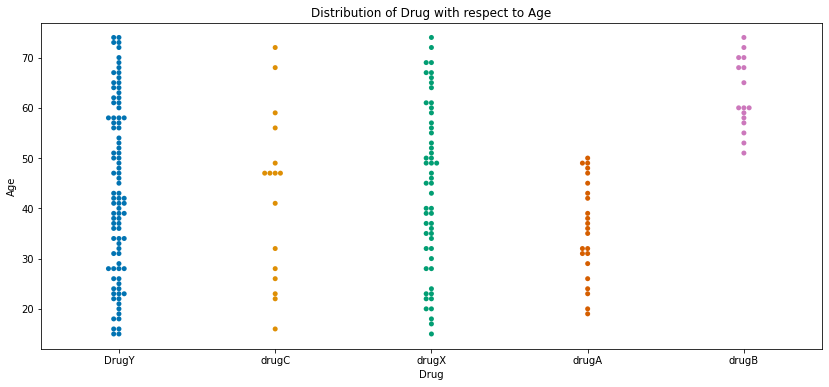

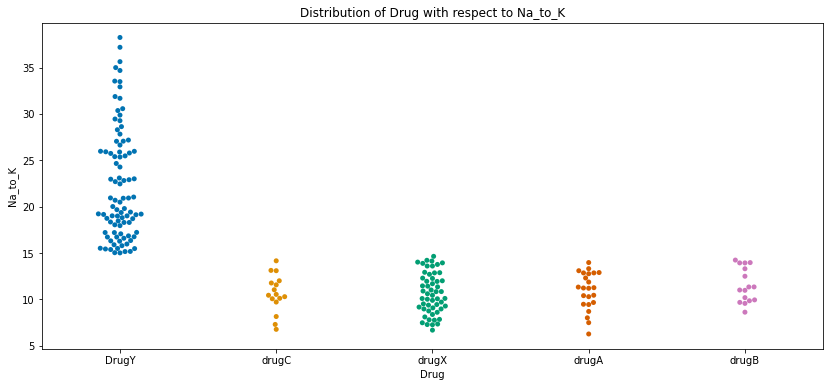

In [8]:
# Bivariate for numerical columns
for col in numerical_cols:
    plt.figure(figsize=(14,6))
    sns.swarmplot(data=explore_df,x='Drug',y=col,palette=vis_color)
    plt.title(f"Distribution of Drug with respect to {col}")

**Inference:** Age may have a correlation with drugA and drugB. Na_to_K appears to have a high correlation to drugY.

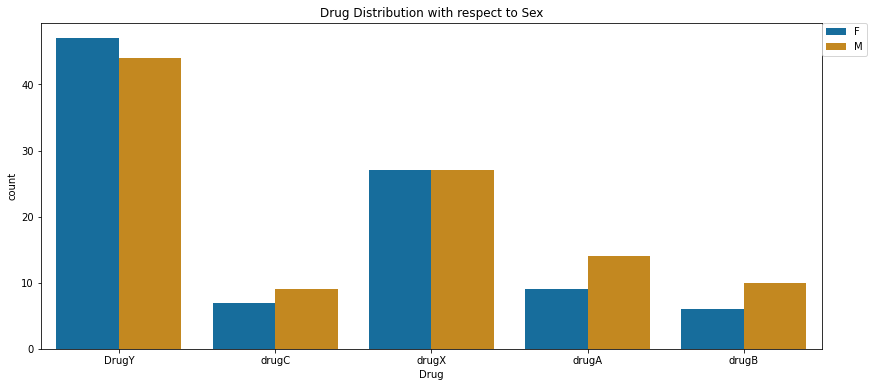

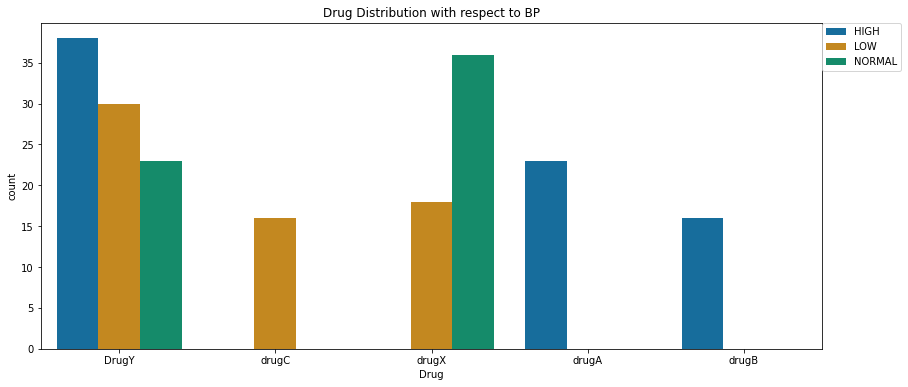

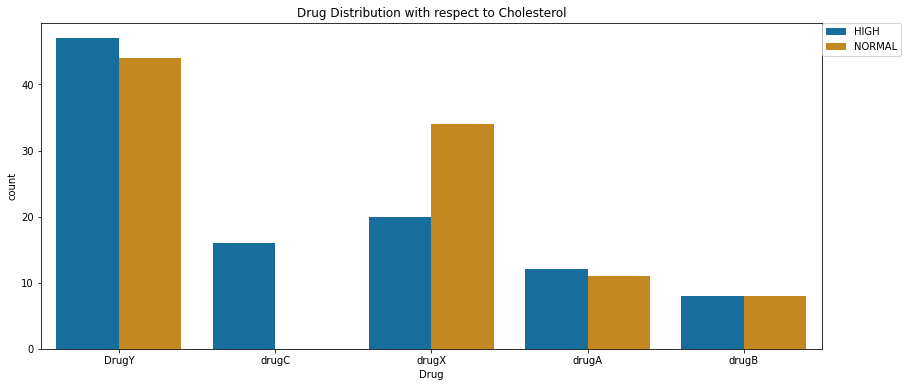

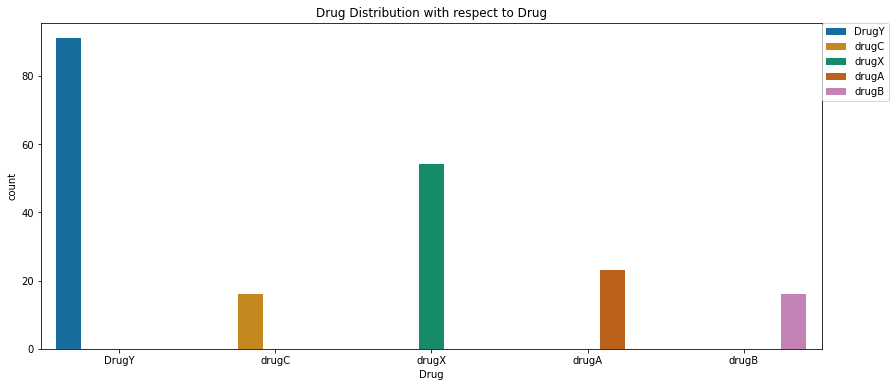

In [9]:
# Bivariate for categorical columns
for col in categorical_cols:  
    plt.figure(figsize=(14,6))
    sns.countplot(data=explore_df,x='Drug',hue=col,palette=vis_color)
    plt.legend(bbox_to_anchor=(1.0,1.0),loc='upper left',borderaxespad=0)
    plt.title(f"Drug Distribution with respect to {col}")

**Inference:** Sex appears to have little influence on which drug is used.

## Multivariate Analysis

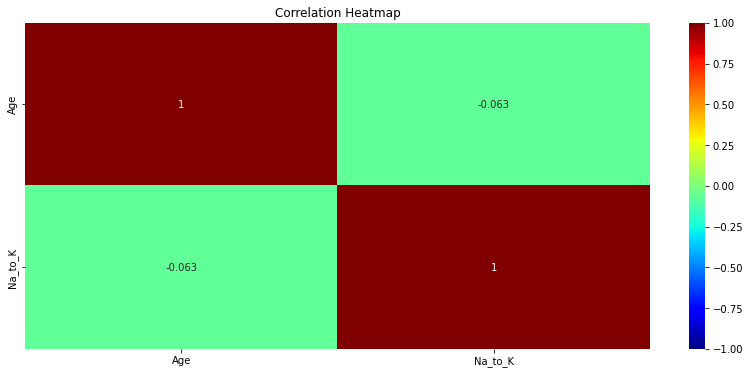

In [10]:
# Create correlation matrix
plt.figure(figsize=(14, 6))
heatmap = sns.heatmap(explore_df.corr(), vmin=-1, vmax=1, annot=True, cmap=cmap_color)
heatmap.set_title('Correlation Heatmap');

Text(0.5, 1.0, 'Distribution of Drug with respect to Na_to_K and Blood Pressure')

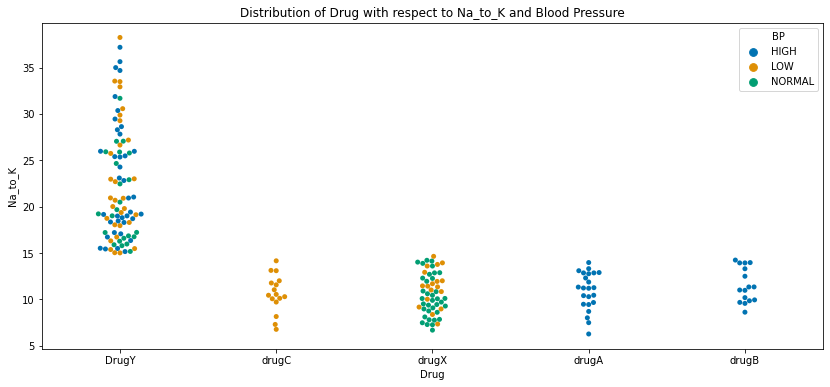

In [11]:
plt.figure(figsize=(14,6))
sns.swarmplot(data=explore_df,x='Drug',y='Na_to_K',hue='BP',palette=vis_color)
plt.title('Distribution of Drug with respect to Na_to_K and Blood Pressure')

## Data Wrangling


The original skewness of Na_to_K
Skewness: 1.039341


The new skewness of Na_to_K
Skewness: 0.673737


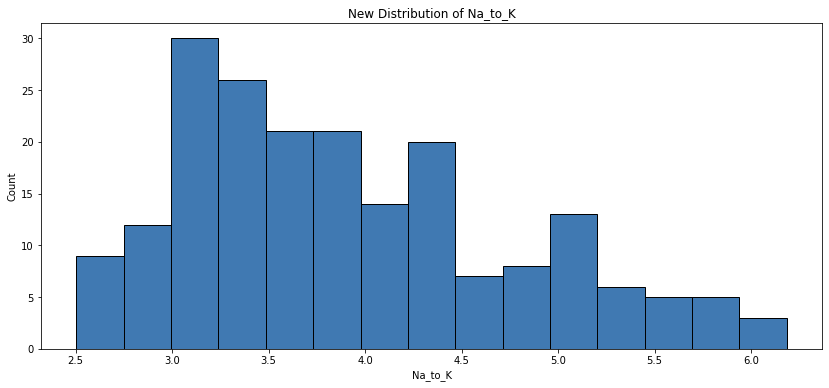

In [12]:
print('The original skewness of Na_to_K')
print("Skewness: %f" % explore_df['Na_to_K'].skew())

print('\n')

# Use log1p to adjust the skewness
explore_df['Na_to_K'] = np.sqrt(explore_df['Na_to_K'])

#Plot new
plt.figure(figsize=(14,6))
sns.histplot(data=explore_df,x='Na_to_K',bins=15,color=hex_color)
plt.title(f"New Distribution of Na_to_K")

print('The new skewness of Na_to_K')
print("Skewness: %f" % explore_df['Na_to_K'].skew())

In [13]:
# Make a new column with Na_to_K greater than 15.0
explore_df['Na_to_K_Greater_Than_15'] = [1 if i >=15.015 else 0 for i in explore_df.Na_to_K]
explore_df.head()

,Age,Sex,BP,Cholesterol,Na_to_K,Drug,Na_to_K_Greater_Than_15
0,23,F,HIGH,HIGH,5.035375,DrugY,0
1,47,M,LOW,HIGH,3.618425,drugC,0
2,47,M,LOW,HIGH,3.180252,drugC,0
3,28,F,NORMAL,HIGH,2.792490,drugX,0
4,61,F,LOW,HIGH,4.247705,DrugY,0


In [14]:
# Drop Sex and Cholesterol as they have little influence on the outcome
explore_df = explore_df.drop(['Sex','Cholesterol'],axis=1) 
explore_df.head()

,Age,BP,Na_to_K,Drug,Na_to_K_Greater_Than_15
0,23,HIGH,5.035375,DrugY,0
1,47,LOW,3.618425,drugC,0
2,47,LOW,3.180252,drugC,0
3,28,NORMAL,2.792490,drugX,0
4,61,LOW,4.247705,DrugY,0


In [15]:
# Split data into features and target
y_df = explore_df['Drug']
X_df = explore_df.drop(['Drug'],axis=1)
X_df

,Age,BP,Na_to_K,Na_to_K_Greater_Than_15
0,23,HIGH,5.035375,0
1,47,LOW,3.618425,0
2,47,LOW,3.180252,0
3,28,NORMAL,2.792490,0
4,61,LOW,4.247705,0
...,...,...,...,...
195,56,LOW,3.401029,0
196,16,LOW,3.464968,0
197,52,NORMAL,3.145473,0
198,23,NORMAL,3.744329,0


In [16]:
# # Encode feature variables
# X_df = pd.get_dummies(X_df,['BP'])
# X_df

In [17]:
# # Encode target variables
# y_df = pd.get_dummies(y_df)
# y_df

## Split, Train, and Test the Data

In [18]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_df, y_df, test_size=0.33, random_state=22)



ValueError: ignored

In [ ]:
# prepare input data
def prepare_inputs(X_train, X_test):
	le = LabelEncoder()
	le.fit(X_train)
	X_train_enc = le.transform(X_train)
	X_test_enc = le.transform(X_test)
	return X_train_enc, X_test_enc
 
# prepare target
def prepare_targets(y_train, y_test):
	le = LabelEncoder()
	le.fit(y_train)
	y_train_enc = le.transform(y_train)
	y_test_enc = le.transform(y_test)
	return y_train_enc, y_test_enc

In [ ]:
# Train the data on the Random Forest Classifier and test the accuracy
rfc = RandomForestClassifier(n_estimators=5,max_depth=5)
rfc.fit(X_train,y_train)

# # Encode feature variables
# pd.get_dummies(X_train)
# pd.get_dummies(y_train)
# pd.get_dummies(X_test)
# pd.get_dummies(y_test)

# Making predictions
y_train_pred = rfc.predict(X_train)
y_test_pred = rfc.predict(X_test)

# Get Scores
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)
print('Results for Random Forest Classifier')
print('The training accuracy is',round((train_accuracy*100),2),'%')
print('The test accuracy is', round((test_accuracy*100),2),'%')


In [ ]:
# # Plot the import features
# feature_importances = pd.DataFrame(rfc.feature_importances_,index=X_df.columns.to_list(),columns=['Importance']).sort_values(by='Importance',ascending=True)
# feature_importances.plot(kind='barh',figsize=(14,6));
# plt.title("Feature Importance",fontsize=20);

In [ ]:
print(classification_report(y_test,y_test_pred))

In [ ]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_df, y_df, test_size=0.33, random_state=22)

# Encode feature variables
X_train = pd.get_dummies(X_train)
y_train = pd.get_dummies(y_train)
X_test = pd.get_dummies(X_test)
y_test = pd.get_dummies(y_test)

In [ ]:
# Train the data on the Random Forest Classifier and test the accuracy
dtc = DecisionTreeClassifier(max_depth=5)
dtc.fit(X_train,y_train)

# Making predictions
y_train_pred = dtc.predict(X_train)
y_test_pred = dtc.predict(X_test)

# Get Scores
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)
print('Results for Decision Tree Classifier')
print('The training accuracy is',round((train_accuracy*100),2),'%')
print('The test accuracy is', round((test_accuracy*100),2),'%')